## Exercises of day 2

- Implement the MUSIC method for estimating the PSD. Test it on the test
  signal from an earlier exercises.
- Show (with pen & paper) how the MUSIC method can be implemented with
  FFTs (not completed) and modify your function to use it.
- Implement the method for model order selection using the  average of 
  the principal angles between subspaces  and try it on the test signal.
- Modify your MUSIC implement to make use of the signal subspace eigenvectors 
  instead of the noise subspace eigenvectors. (not completed)
- Implement, in a function, the classical Capon PSD estimator. Test in on the test signal. 
- Implement the APES spectral estimator and test it.
- Compare the PSD estimates obtained with the two methods. What do you observe?


In [1]:
# imports
import numpy as np
from matplotlib import pyplot as plt

Define a function to generate a signal of K sinusoids

In [2]:
def generate_signal(N, fs, K, plot=False):
    """
    Generate a complex signal composed of K sinusoids with random amplitudes, frequencies, and phases,
    contaminated by complex Gaussian noise.

    Parameters
    ----------
    N : int
        Number of samples.
    fs : float
        Sampling frequency.
    K : int
        Number of sinusoids (signal order).
    plot : bool, optional
        If True, plot the real and imaginary parts of the generated signal.

    Returns
    -------
    x : np.ndarray
        The generated complex signal (length N).
    fs : float
        The sampling frequency.
    f : np.ndarray
        Array of the true frequencies of the sinusoids (length K).
    """
    np.random.seed(42)
    t = np.arange(N) / fs

    a = np.random.normal(0, 10, K)
    f = np.random.uniform(0, fs/2, K)
    phi = np.random.uniform(-np.pi, np.pi, K)

    a = a[:, np.newaxis]
    f = f[:, np.newaxis]
    phi = phi[:, np.newaxis]
    t = t[np.newaxis, :]
    x = np.sum(a * np.exp(1j * 2 * np.pi * f * t + 1j * phi), axis=0)

    noise_real = np.random.normal(0, 5, size=N)
    noise_imag = np.random.normal(0, 5, size=N)
    noise = noise_real + 1j * noise_imag

    x = x + noise

    if plot:
        plt.figure()
        plt.plot(range(N), x.real, label="Real part")
        plt.plot(range(N), x.imag, label="Imag part")
        plt.legend()
        plt.title(f"Complex Signal (N={N}, order={K})")
        plt.xlabel("Time [s]")
        plt.tight_layout()

    return x, fs, f

Implementing MUSIC

In [3]:
class Music():
    def __init__(self, x, p, d, use_fft=False):
        """
        Initialize the MUSIC estimator.

        Parameters
        ----------
        x : np.ndarray
            Input signal (1D array).
        p : int
            Model order (number of lags).
        d : int
            Number of sinusoids (signal subspace dimension).
        use_fft : bool, optional
            If True, use FFT-based implementation for PSD estimation.
        """
        self.x = x      # input signal
        self.N = len(x) # number of samples
        self.p = p      # model order
        self.d = d      # signal subspace dimension
        self.use_fft = use_fft

        self.Rhat, self.Rinv = self._build_rhat()
        self.evals, self.evecs = self._get_eigen()

        if use_fft:
            self.Pxx, self.freqs = self._get_pxx_fourier()
        else:
            self.Pxx, self.freqs = self._get_pxx()


    def _build_rhat(self):
        self.L = self.p + 1
        Nsnap = self.N - self.p
        Y = np.zeros((self.L, Nsnap), dtype=complex)
        for tt in range(Nsnap):
            Y[:, tt] = self.x[tt:tt+self.L][::-1]

        self.Y = Y
        Rhat = (Y @ Y.conj().T) / Nsnap

        Rinv = np.linalg.inv(Rhat)
        return Rhat, Rinv 
    

    def _get_eigen(self):
        evals, evecs = np.linalg.eigh(self.Rhat)
        idx = np.argsort(evals)[::-1]
        return evals[idx], evecs[:, idx]


    def _get_pxx(self):
        freqs = np.linspace(0, 0.5, self.N)
        P_music = np.zeros(self.N)
        for k, f in enumerate(freqs):
            a = np.exp(-1j * 2*np.pi * np.arange(self.L) * f).reshape(-1,1)
            denom = np.linalg.norm(self.evecs[:, self.d:].conj().T @ a)**2
            P_music[k] = 1.0/denom if denom > 0 else 0.0
        
        P_music = P_music / P_music.max()
        return P_music, freqs

    def _get_pxx_fourier(self):
        freqs = np.linspace(0, 0.5, self.N)
        P_music = np.zeros(2*self.N)
 
        for i in range(self.evecs[:, self.d:].shape[1]):
            fft_vals = np.fft.fft(self.evecs[:, self.d:][:, i], n=2*self.N)
            P_music += np.abs(fft_vals)**2

        P_music = 1.0 / P_music
        P_music = P_music[:self.N] + P_music[-self.N:][::-1]  # combine positive and negative freqs
        
        P_music = P_music / P_music.max()
        return P_music, freqs

    def plot(self, show=True):
        if show:
            plt.figure()
        plt.plot(self.freqs, self.Pxx, label=f'model order: {self.p}, assumed sinusoids: {self.d}')
        if self.use_fft:
            plt.title("MUSIC (FFT) PSD Estimate")
        else:
            plt.title("MUSIC PSD Estimate")
        plt.xlabel("Frequency (normalized)")
        plt.ylabel("Power (relative)")
        plt.grid()
        plt.tight_layout()
        if show:
            plt.show()

Implementing Capon

In [4]:
class Capon():
    def __init__(self, x: np.ndarray, p: int):
        """
        Initialize the Capon (MVDR) PSD estimator.

        Parameters
        ----------
        x : np.ndarray
            Input signal (1D array).
        p : int
            Model order (number of lags).

        Attributes
        ----------
        x : np.ndarray
            Input signal.
        N : int
            Number of samples in the input signal.
        p : int
            Model order.
        Rhat : np.ndarray
            Estimated autocorrelation matrix.
        Rinv : np.ndarray
            Inverse of the autocorrelation matrix.
        Pxx : np.ndarray
            Power spectral density estimate.
        freqs : np.ndarray
            Frequency bins corresponding to the PSD estimate.
        """
        self.x = x      # input signal
        self.N = len(x) # number of samples
        self.p = p      # model order
        self.Rhat, self.Rinv = self._build_rhat()
        self.Pxx, self.freqs = self._get_pxx()


    def _build_rhat(self):
        L = self.p + 1
        Nsnap = self.N - self.p
        Y = np.zeros((L, Nsnap), dtype=complex)
        for tt in range(Nsnap):
            Y[:, tt] = self.x[tt:tt+L][::-1]

        self.Y = Y
        Rhat = (Y @ Y.conj().T) / Nsnap

        Rinv = np.linalg.inv(Rhat)
        return Rhat, Rinv


    def _get_pxx(self):
        L = self.p + 1
        freqs = np.linspace(0, 0.5, self.N, endpoint=True)
        a_all = np.exp(-1j * 2*np.pi * np.outer(np.arange(L), freqs))
        P_capon = np.zeros(self.N)
        for n in range(self.N):
            a = a_all[:, n].reshape(-1,1)
            denom = (a.conj().T @ self.Rinv @ a).item()
            P_capon[n] = 1.0 / np.real(denom) 

        P_capon /= P_capon.max()
        return P_capon, freqs
    

    def plot(self, show=True):
        if show:
            plt.figure()
        plt.plot(self.freqs, self.Pxx, label=f'model order: {self.p}')
        plt.title("Capon (MVDR) PSD Estimate")
        plt.xlabel("Frequency (normalized)")
        plt.ylabel("Power (relative)")
        plt.grid()
        plt.tight_layout()
        if show:    
            plt.show()

Implementing APES

In [5]:
class Apes():
    def __init__(self, x: np.ndarray, p: int):
        """
        Initialize the APES (Amplitude and Phase EStimation) PSD estimator.

        Parameters
        ----------
        x : np.ndarray
            Input signal (1D array).
        p : int
            Model order for the APES algorithm.

        Attributes
        ----------
        x : np.ndarray
            Input signal.
        N : int
            Number of samples in the input signal.
        p : int
            Model order.
        Rhat : np.ndarray
            Estimated autocorrelation matrix.
        Rinv : np.ndarray
            Inverse of the autocorrelation matrix.
        Pxx : np.ndarray
            Power spectral density estimate.
        freqs : np.ndarray
            Frequency bins corresponding to the PSD estimate.
        """
        self.x = x      # input signal
        self.N = len(x) # number of samples
        self.p = p      # model order
        self.Rhat, self.Rinv = self._build_rhat()
        self.Pxx, self.freqs = self._get_pxx()


    def _build_rhat(self):
        L = self.p + 1
        Nsnap = self.N - self.p
        Y = np.zeros((L, Nsnap), dtype=complex)
        for tt in range(Nsnap):
            Y[:, tt] = self.x[tt:tt+L][::-1]

        self.Y = Y

        Rhat = (Y @ Y.conj().T) / Nsnap
        Rinv = np.linalg.inv(Rhat)

        return Rhat, Rinv
   

    def _get_pxx(self):
        L = self.p + 1
        Nsnap = self.N - self.p
        freqs = np.linspace(0, 0.5, self.N, endpoint=True)
        time_indices = np.arange(self.p, self.N)

        P_apes = np.zeros(self.N)        
        beta = np.zeros(self.N, dtype=complex)

        a_all = np.exp(-1j * 2*np.pi * np.outer(np.arange(L), freqs))
        exponent = np.exp(-1j * 2*np.pi * np.outer(time_indices, freqs))
        g_all = (self.Y @ exponent) / Nsnap

        for k in range(self.N):
            a = a_all[:, k].reshape(-1,1)
            g = g_all[:, k].reshape(-1,1) 
            num = (a.conj().T @ self.Rinv @ g).item()
            term = (g.conj().T @ self.Rinv @ g).item()
            denom = (1 - term) * (a.conj().T @ self.Rinv @ a).item() + np.abs(num)**2

            if np.abs(denom) < 1e-12:
                beta_k = 0.0 + 0.0j
            else:
                beta_k = num / denom
            beta[k] = beta_k
            P_apes[k] = np.abs(beta_k)**2
        
        P_apes /= P_apes.max()
        return P_apes, freqs

    
    def plot(self, show=True):
        if show:
            plt.figure()
        plt.plot(self.freqs, self.Pxx, label=f'model order: {self.p}, frequency bins: {self.N}')
        plt.title("APES PSD Estimate")
        plt.xlabel("Frequency (normalized)")
        plt.ylabel("Power (relative)")
        plt.grid()
        plt.tight_layout()
        if show:
            plt.show()

In [6]:
# set parameters
fs = 8000 
N = 1024

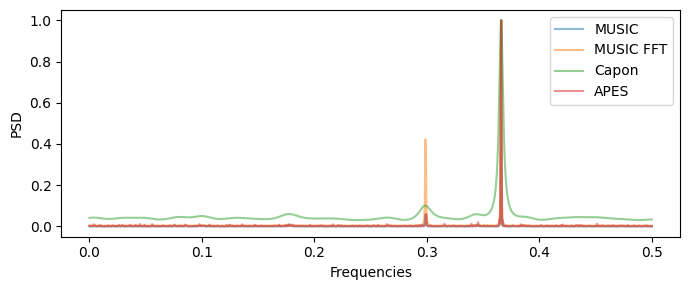

In [7]:
x, fs, true_freqs = generate_signal(N=N, fs=fs, K=2, plot=False)

music_estimator = Music(x, p=50, d=15)

music_estimator_fft = Music(x, p=100, d=2, use_fft=True)

capon_estimator = Capon(x, p=50)

apes_estimator = Apes(x, p=50)


plt.figure(figsize=(7,3))
plt.plot(music_estimator.freqs, music_estimator.Pxx, alpha=0.5, label='MUSIC')
plt.plot(music_estimator_fft.freqs, music_estimator_fft.Pxx, alpha=0.5, label='MUSIC FFT')
plt.plot(capon_estimator.freqs, capon_estimator.Pxx, alpha=0.5, label='Capon')
plt.plot(apes_estimator.freqs, apes_estimator.Pxx, alpha=0.5, label='APES')
plt.xlabel('Frequencies')
plt.ylabel('PSD')
plt.legend()
plt.tight_layout()
plt.show()